<a href="https://colab.research.google.com/github/lakshya0904/Crop-Yield-Prediction/blob/main/sop_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join

In [ ]:
    
    def load_clean_yield_data(yield_data_filepath):
        """
        Cleans the yield data by making sure any Nan values in the columns we care about
        are removed
        """
        important_columns=['Year', 'State ANSI', 'County ANSI', 'Value']
        yield_data=pd.read_csv(yield_data_filepath).dropna(subset=important_columns,how='any')

        return yield_data

    def get_tif_files(image_path):
        """
        Get all the .tif files in the image folder.

        Parameters
        ----------
        image_path: pathlib Path
            Directory to search for tif files
        Returns:
            A list of .tif filenames
        """
        files = []
        for dir_file in image_path.iterdir():
            # print("dir_file")
            # print(str(dir_file))
            if str(dir_file).endswith('tif'):
                # strip out the directory so its just the filename
                files.append(str(dir_file.parts[-1]))
                # print(str(dir_file.parts[-1]))
        return files
    def get_tif_files_12(image_path):#name length less than 12
        """
        Get all the .tif files in the image folder.

        Parameters
        ----------
        image_path: pathlib Path
            Directory to search for tif files
        Returns:
            A list of .tif filenames
        """
        files = []
        for dir_file in image_path.iterdir():
            # print("dir_file")
            # print(str(dir_file))
            if str(dir_file).endswith('tif'):
                # strip out the directory so its just the filename
                if len(str(dir_file.parts[-1]))<12:#max possible name is ss_ccc.tif, len=10
                    files.append(str(dir_file.parts[-1]))
                # print(str(dir_file.parts[-1]))
        return files
    def get_tif_files_12(mask_path,temperature_path,image_path,weather_path):
#         print(len(mask_path.iterdir()))
        print(len([1 for x in list(os.scandir(mask_path)) if x.is_file()]))
        print(len([1 for x in list(os.scandir(temperature_path)) if x.is_file()]))
        print(len([1 for x in list(os.scandir(image_path)) if x.is_file()]))
        print(len([1 for x in list(os.scandir(weather_path)) if x.is_file()]))
        mask_files=[f for f in listdir(mask_path) if isfile(join(mask_path, f))]
        print("\n\n")
        print(mask_files)
        temperature_files=[f for f in listdir(temperature_path) if isfile(join(temperature_path, f))]
        print("\n\n")
        print(temperature_files)
        image_files=[f for f in listdir(image_path) if isfile(join(image_path, f))]
        print("\n\n")
        print(image_files)
        weather_files=[f for f in listdir(weather_path) if isfile(join(weather_path, f))]
        print("\n\n")
        print(weather_files)
        files = []
        for dir_file in image_path.iterdir():
            # print("dir_file")
            # print(str(dir_file))
            if str(dir_file).endswith('tif'):
                # strip out the directory so its just the filename
                if len(str(dir_file.parts[-1]))<12:#max possible name is ss_ccc.tif, len=10
                    if str(dir_file.parts[-1]) in temperature_files:
                        if str(dir_file.parts[-1]) in weather_files:
                            if str(dir_file.parts[-1]) in mask_files:
                                files.append(str(dir_file.parts[-1]))
                # print(str(dir_file.parts[-1]))
        return files


In [ ]:
#for exporting from ee to drive
import ee
import ssl
import time
from pathlib import Path
import numpy as np
np.set_printoptions(threshold=np.inf)

In [ ]:
MAJOR_STATES=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 17, 18, 19, 20, 26, 27, 28, 29, 31, 38, 39, 46, 47, 55]
# MAJOR_STATES=[1, 5, 17, 18, 19, 20, 27, 29, 31, 38, 39, 46]

In [ ]:
class ModisExporter:
    """A class to export MODIS data from 
    Google Earth Engine to Google Drive

    Parameters"""

    def __init__(self, locations_filepath=Path('SOP_download/yield_data.csv'),collection_id='MODIS/006/MOD09A1'):#006 instead of 051
        self.locations=load_clean_yield_data(locations_filepath)
        self.collection_id=collection_id

        try:
            # https://developers.google.com/earth-engine/guides/python_install-colab
            # Trigger the authentication flow.
            # Google Earth Engine Python Authenticator
            ee.Authenticate()
            # Initialize the Earth Engine module.
            ee.Initialize()
            print('Earth Engine initialized successfully!!')
        except ee.EEException:
            print('Earth Engine failed to initialize. Use authenticate in command line.')
        
    def update_parameters(self, location_filepath=None,collection_id=None):
        """
        Update the locations file or the collection id
        """
        if location_filepath is not None:
            # self.locations=load(locations_filepath)
            # from utils import load_clean_yield_data as load
            self.locations=load_clean_yield_data(locations_filepath)
        if collection_id is not None:
            self.collection_id=collection_id

    @staticmethod
    def _export_one_image(img,folder, name, region, scale, crs):
        # export one image from Earth Engine to Google Drive
        print(f'Exporting to {folder}/{name}')
        task_dict={
            'folder': folder,
            'fileNamePrefix': name,
            'scale': scale,
            'crs': crs
        }
        if region is not None:
            task_dict.update({
                'region': region
            })
        task=ee.batch.Export.image.toDrive(img,name, **task_dict)
        task.start()
        while task.status()['state']=='RUNNING':
            print('Running....')
            # perhaps task.cancel() at some point
            time.sleep(10)
        print(f'Done: {task.status()}')
    
    def export(self, folder_name, data_type, coordinate_system='EPSG:4326', scale=500,
               export_limit=None, min_img_val=None, max_img_val=None, major_states_only=True,
               check_if_done=False, download_folder=None):
        """Export an Image Collection from Earth Engine to Google Drive
        Parameters
        ----------
            folder_name: str
                The name of the folder to export the images to in
                Google Drive. If the folder is not there, this process
                creates it
            data_type: str {'image', 'mask', 'temperature'}
                The type of data we are collecting. This tells us which bands to collect.
            coordinate_system: str, default='EPSG:4326'
                The coordinate system in which to export the data
            scale: int, default=500
                The pixel resolution, as determined by the output.
                https://developers.google.com/earth-engine/scale
            export_limit: int or None, default=None
                If not none, limits the number of files exported to the value
                passed.
            min_img_val = int or None:
                A minimum value to clip the band values to
            max_img_val: int or None
                A maximum value to clip the band values to
            major_states_only: boolean, default=True
                Whether to only use the 11 states responsible for 75 % of national soybean
                production, as is done in the paper
            check_if_done: boolean, default=False
                If true, will check download_folder for any .tif files which have already been
                downloaded, and won't export them again. This effectively allows for
                checkpointing, and prevents all files from having to be downloaded at once.
            download_folder: None or pathlib Path, default=None
                Which folder to check for downloaded files, if check_if_done=True. If None, looks
                in data/folder_name
        """

        if check_if_done:
            if download_folder is None:
                # download_folder=Path('data')/folder_name    #DATA folder???
                download_folder=Path('')/folder_name
                # folder_names is passed as 'SOP- Time Series Analysis with Deep Learning/crop_yield-data_image', etc...
                already_downloaded= get_tif_files(download_folder)

        # imgcoll=ee.ImageCollection(self.collection_id)\
        #     .filterBounds(ee.Geometry(-106.5,50,-64,23))\
        #     .filterDate('2002-12-31','2016-8-4')
        imgcoll = ee.ImageCollection(self.collection_id) \
            .filterBounds(ee.Geometry.Rectangle(-106.5, 50, -64, 23)) \
            .filterDate('2002-12-31', '2012-12-31')

        datatype_to_func={
            'image': _append_im_band,
            'mask': _append_mask_band,
            'temperature': _append_temp_band,
            'weather': _append_weather_band
        }
        

        img = imgcoll.iterate(datatype_to_func[data_type])#data_type-> whether it is image, mask or temperature
        #stacking images all over the years for particular state and county
        img=ee.Image(img)   #need to explicitly use ee.Image because .iterate function returns Object

        if min_img_val is not None:
            # passing an ee.Number creates a constant image
            img_min=ee.Image(ee.Number(min_img_val))
            img=img.min(img_min)


        if max_img_val is not None:
            # passing an ee.Number creates a constant image
            img_max=ee.Image(ee.Number(max_img_val))
            img=img.max(img_max)

       
        region = ee.FeatureCollection('TIGER/2018/Counties')

        
        # https://developers.google.com/earth-engine/datasets/catalog/TIGER_2018_Counties
        def state_to_int(feature):
            return feature.set('COUNTYFP', ee.Number.parse(feature.get('COUNTYFP')))#how we got to know about string 'COUNTYFP' what does this mean
        region=region.map(state_to_int)

        count=0
        for state_id, county_id in np.unique(self.locations[['State ANSI','County ANSI']].values,axis=0):
            if major_states_only:
                if (int)(state_id) not in MAJOR_STATES:
                    print(f'Skipping state id {int(state_id)}')
                    continue
            fname='{}_{}'.format(int(state_id),int(county_id))

            if check_if_done:
                if f'{fname}.tif' in already_downloaded:
                    print(f'{fname}.tif already downloaded! Skipping')
                    continue
            
            file_region=region.filterMetadata('COUNTYFP','equals', int(county_id))
            file_region=ee.Feature(file_region.first())

        
            processed_img=img.clip(file_region)

        

            file_region=None
            while True:
                # try:
                self._export_one_image(processed_img,folder_name,fname, file_region, scale, coordinate_system)
                # except (ee.ee_exception.EEException, ssl.SSLEOFError):
                #     print(f'Retrying State {int(state_id)}, County  {int(county_id)}')
                #     # print(f'Unable to export State {int(state_id)}, County  {int(county_id)}, so skipping')
                #     # break
                    # time.sleep(10)
                    # continue
                break

            count+=1
            if export_limit:
                if count>=export_limit:
                    print('Reached export limit!! Stopping...')
                    break
        print(f'Finished Exporting {count} files!')


    def export_all(self,export_limit=None, major_states_only=True, check_if_done=True,
                   download_folder=None):
        """
        Export all the data.
        download_folder = list of 3 pathlib Paths, for each of the 3 downloads
        """
        if download_folder is None:
            download_folder=[None]*4
        assert len(download_folder)==4, "Must have 3 download folders for the 3 exports!"

        #first, make sure the class was initialized correctly
        # self.update_parameters(locations_filepath=load_clean_yield_data('SOP- Time Series Analysis with Deep Learning/yield_data.csv'),
                            #    collection_id='MODIS/MOD09A1')
        
        
        self.export(folder_name='crop_yield_image', data_type='image',
                    min_img_val=16000, max_img_val=100,
                    export_limit=export_limit, major_states_only=major_states_only,
                    check_if_done=check_if_done, download_folder=download_folder[0])

        # pull_MODIS_landcover_entire_county_clip.py
        self.update_parameters(collection_id='MODIS/006/MCD12Q1')
        self.export(folder_name='crop_yield_mask', data_type='mask',
                    export_limit=export_limit, major_states_only=major_states_only,
                    check_if_done=check_if_done, download_folder=download_folder[1])

        # pull_MODIS_temperature_entire_county_clip.py
        self.update_parameters(collection_id='MODIS/006/MOD11A2')
        self.export(folder_name='crop_yield_temp', data_type='temperature',
                    export_limit=export_limit, major_states_only=major_states_only,
                    check_if_done=check_if_done, download_folder=download_folder[2])
        
        self.update_parameters(collection_id="NASA/ORNL/DAYMET_V3")
        self.export(folder_name='crop_yield_daymet', data_type='weather',
                    export_limit=export_limit, major_states_only=major_states_only,
                    check_if_done=check_if_done, download_folder=download_folder[3])



        print('Done exporting! Download the folders from your Google Drive')



    # first call current=1st image, previous=none, return 1st image
    # 2nd call current, 2nd image, first
    # 1_1, 1_2, 1_3, 2_1, 2_2, 2_3
def _append_im_band(current,previous):                                  
    # Transforms an Image Collection with 1 band per Image into a single Image with items as bands
    
    #Rename the band
    previous=ee.Image(previous)
    current=current.select([0, 1, 2, 3, 4, 5, 6])
    # Append it to the result (Note: only return current item on first element/iteration)
    return ee.Algorithms.If(ee.Algorithms.IsEqual(previous,None),current,previous.addBands(ee.Image(current)))
    # so basically we are adding bands here, and now our final image have all images and their corresponding bands

def _append_mask_band(current,previous):
    # Transforms an Image Collection with 1 band per Image into a single Image with items as bands
    
    # Rename the band
    previous=ee.Image(previous)
    current=current.select([0])
    # Append it to the result (Note: only return current item on first element/iteration)
    return ee.Algorithms.If(ee.Algorithms.IsEqual(previous,None),current,previous.addBands(ee.Image(current)))

def _append_temp_band(current,previous):
    # Transforms an Image Collection with 1 band per Image into a single Image with items as bands
    
    # Rename the band
    previous=ee.Image(previous)
    current=current.select([0,4])
    # Append it to the result (Note: only return current item on first element/iteration)
    return ee.Algorithms.If(ee.Algorithms.IsEqual(previous, None), current, previous.addBands(ee.Image(current)))

def _append_weather_band(current,previous):
    # Transforms an Image Collection with 1 band per Image into a single Image with items as bands
    
    # Rename the band
    previous=ee.Image(previous)
    current=current.select([1,6])
    # Append it to the result (Note: only return current item on first element/iteration)
    return ee.Algorithms.If(ee.Algorithms.IsEqual(previous, None), current, previous.addBands(ee.Image(current)))




In [ ]:
yield_data_path='SOP_download/yield_data.csv' #taken from pycrop
                                                                # putting less entries
yield_data_path = Path(yield_data_path)
exporter = ModisExporter(locations_filepath=yield_data_path)
exporter.export_all()

In [ ]:
#Here goes preprocessing part

In [ ]:
image=np.transpose(np.array(gdal.Open(str('/home/mpiuser/Downloads/image/31_23.tif')).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
#print()

In [ ]:
# print(np.count(image[:,:,:]==12))
print(np.count_nonzero(image == 1112))

5535


In [ ]:
#nnfl_cyp_save_hist
from pathlib import Path
import numpy as np
import gdal
import math
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor


In [ ]:
class DataCleaner:
    """Take the exported, downloaded data
    and clean it.

    Specifically:
    - split the image collections into years
    - merge the temperature and reflection images
    - apply the mask, so only the farmland pixels are considered

    Parameters
    -----------
    mask_path: pathlib Path, default=Path('data/crop_yield-data_mask')
        Path to which the mask tif files have been saved
    temperature_path: pathlib Path, default=Path('data/crop_yield-data_temperature')
        Path to which the temperature tif files have been saved
    image_path: pathlib Path, default=Path('data/crop_yield-data_image')
        Path to which the image tif files have been saved
    yield_data: pathlib Path, default=Path('data/yield_data.csv')
        Path to the yield data csv file
    savedir: pathlib Path, default=Path('data/img_output')
        Path to save the data to
    multiprocessing: boolean, default=False
        Whether to use multiprocessing
    """

    def __init__ (self,mask_path=Path('/content/drive/MyDrive/crop_yield-data_mask_aditya'),
                  temperature_path=Path('/content/drive/MyDrive/crop_yield-data_temperature_aditya'),
                  image_path=Path('/content/drive/MyDrive/crop_yield-data_image_aditya'),
                  weather_path = Path('/content/drive/MyDrive/Daymet_data'),
                  yield_data_path=Path('SOP_download/yield_data.csv'),
                  savedir=Path('/content/drive/MyDrive/img_output'),
                  multiprocessing=False, processes=4, parallelism=6):
        self.mask_path=mask_path;
        self.temperature_path=temperature_path;
        self.image_path=image_path;
        self.weather_path = weather_path
        self.tif_files=get_tif_files_12(self.mask_path,self.temperature_path,self.image_path,self.weather_path)
        self.tif_files.sort()
        for x in range(100):
            self.tif_files.insert(0, self.tif_files.pop())
            # self.tif_files=self.tif_files[1:] + self.tif_files[0]
        # self.tif_files.sort(reverse=True)
        # self.tif_files.reverse()
        # simply as read by library
        self.multiprocessing=multiprocessing;
        self.processes=processes;
        self.parallelism=parallelism

        self.savedir = savedir
        if not self.savedir.exists():
            self.savedir.mkdir()

        self.yield_data=load_clean_yield_data(yield_data_path)[['Year', 'State ANSI', 'County ANSI']].values.astype(int) #.astype(int) added to avoid floating values read
        
    
    def process(self, num_years=14, delete_when_done=False):
        """
        Process all the data.

        Parameters
        ----------
        num_years: int, default=14
            How many years of data to create.
        delete_when_done: boolean, default=False
            Whether or not to delete the original .tif files once the .npy array
            has been generated.
        """
        print("#counties available: ")
        print(len(self.tif_files))
        # print("0")
        # print(image_path.iterdir())
    
        files = []
        for dir_file in image_path.iterdir():
            # print("dir_file")
            # print(str(dir_file))
            if str(dir_file).endswith('tif'):
                # strip out the directory so its just the filename
                # print(len(str(dir_file.parts[-1])))
                if len(str(dir_file.parts[-1]))<12:#max possible name is ss_ccc.tif, len=10
                    # print(len(str(dir_file.parts[-1])))
                    files.append(str(dir_file.parts[-1]))#basically taking out filename only
                # print(str(dir_file.parts[-1]))
        # print(tif_files)
        print(len(files))

      
        if delete_when_done:
            print('Warning!! delete_when_done=True will delete the .tif files')
        
        if not self.multiprocessing:
            for filename in self.tif_files:
                # print(filename)
                process_county(filename, self.savedir, self.image_path, self.mask_path,
                               self.temperature_path, self.weather_path,self.yield_data, num_years=num_years, 
                               delete_when_done=delete_when_done)
               
        else:
            length=len(self.tif_files)
            files_iter=iter(self.tif_files)
            # for i in self.tif_files:
            #     print(i)
            #working fine!!
            # print(self.savedir)#fine

            # turn all other arguments to iterator
            savedir_iter=repeat(self.savedir)
            im_path_iter=repeat(self.image_path)
            mask_path_iter=repeat(self.mask_path)
            temp_path_iter=repeat(self.temperature_path)
            weat_path_iter = repeat(self.weather_path)
            yd_iter=repeat(self.yield_data)
            num_years_iter=repeat(num_years)
            delete_when_done_iter=repeat(delete_when_done)

            with ProcessPoolExecutor() as executor:
                chunksize= int(max(length/(self.processes*self.parallelism),1))
                # print(self.processes)
                # print(self.parallelism)
                # print(chunksize)
                executor.map(process_county, files_iter, savedir_iter, im_path_iter,mask_path_iter,
                             temp_path_iter, weat_path_iter,yd_iter, num_years_iter, delete_when_done_iter,
                             chunksize=chunksize)

def process_county(filename, savedir, image_path, mask_path, temperature_path, weather_path,yield_path,
                    num_years, delete_when_done):
    """
    Process and save county level data
    """

    # exporting part saves files in "{state}_{county}_.tif" format
    # so the last 4 characters are always .tif
    #print("2")
    print("process_county \t",filename)
    locations=filename[:-4].split("_")
    state, county=int(locations[0]), int(locations[1])

    image=np.transpose(np.array(gdal.Open(str(image_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    temp=np.transpose(np.array(gdal.Open(str(temperature_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    mask=np.transpose(np.array(gdal.Open(str(mask_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    weather = np.transpose(np.array(gdal.Open(str(weather_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    
    # print(weather.shape," ",image.shape," ",temp.shape,"\n")

    temp = temp-12400
        # scale
    temp = temp*1.5625  #considering 12400 (0) to 15600 (5000)
    # clean
    temp[temp<0]=0
    temp[temp>5000]=5000

    image = image-1
    image[image<0]=0
    image[image>5000]=5000

    weather[:,:,0:weather.shape[2]:2] = weather[:,:,0:weather.shape[2]:2]*(5000/35)  #considering 12400 (0) to 15600 (5000)
    # clean
    weather[:,:,1:weather.shape[2]:2] = weather[:,:,1:weather.shape[2]:2]*(5000/3200)
    weather[weather<0]=0
    weather[weather>5000]=5000


    # a values of 12 indicates farmland: everything else, we want to ignore
    mask[mask!=12]=0
    mask[mask==12]=1
    #print(mask)
    # print("1")
    # when exporting the image, we append bands from many years into a single image for efficiency.
    # We want to split it back now
    img_temp_weat_merge = []
    # num bands and composite perios from the MODIS website
    img_list= divide_into_years(image, bands=7, composite_period=8, num_years=num_years)
    
    mask_list= divide_into_years(mask, bands=1, composite_period=365, num_years=num_years, extend=True)
    
    temp_list= divide_into_years(temp, bands=2, composite_period=8, num_years=num_years)
    
    weat_list= divide_into_years_daymet(weather, bands = 2, composite_period=1, num_years= num_years) #divide_into_years(weather, bands=2, composite_period=8, num_years=num_years)
    
    img_temp_weat_merge = merge_image_lists(img_list, 7, temp_list, 2, weat_list, 2)
    
    masked_img_temp_weat = mask_image(img_temp_weat_merge, mask_list)
    
    start_year=2006 #start year from the modis website
    
    for i in range(0,num_years):
        year=i+start_year
        # print(i)
        key=np.array([year,state,county])
        # print("3")
        fname='{}_{}_{}'.format(int(year),int(state),int(county))
        # save_filename='{year}_{state}_{county}'
        save_filename=fname;
        # print("saving file",save_filename)
        np.save(savedir/save_filename, masked_img_temp_weat[i])
        print("saving file",save_filename)
        # print("saved\n")

    if delete_when_done:
        (image_path/filename).unlink()
        (temperature_path/filename).unlink()
        (mask_path/filename).unlink()
        (weather_path/filename).unlink()
    
    print(f'{filename} array written')


# helper methods for the data cleaning

def divide_into_years(img, bands, composite_period, num_years=10, extend=False):
    """
    Parameters
    ----------
    img: the appended image collection to split up
    bands: the number of bands in an individual image
    composite_period: length of the composite period, in days
    num_years: how many years of data to create.
    extend: boolean, default=False
        If true, and num_years > number of years for which we have data, then the extend the image
        collection by copying over the last image.
        NOTE: This is different from the original code, where the 2nd to last image is copied over

    Returns:
    ----------
    im_list: a list of appended image collections, where each element in the list is a year's worth
        of data
    """
    bands_per_year=bands*math.ceil(365/composite_period)

    # if necessary, pad the image collection with the final images
    if extend: 
        num_bands_necessary=bands_per_year*num_years
        while img.shape[2]<num_bands_necessary:
            img=np.concatenate((img, img[:, :, -bands:]),axis=2)

    image_list=[]
    cur_idx=0
    for i in range(0, num_years-1):
        image_list.append(img[:,:,cur_idx:cur_idx+bands_per_year])
        cur_idx+=bands_per_year
    image_list.append(img[:,:,cur_idx:cur_idx+bands_per_year])
    return image_list

def divide_into_years_daymet(img, bands, composite_period, num_years=10, extend=False):
    # bands=2
    # composite_period=1
    bands_per_year=bands*math.ceil(365/composite_period)

    # print("a")

    # if necessary, pad the image collection with the final images
    if extend: 
        num_bands_necessary=bands_per_year*num_years
        while img.shape[2]<num_bands_necessary:
            img=np.concatenate((img, img[:, :, -bands:]),axis=2)
        
            
    
    # d1b1 d1b2 d2b1 d2b2 d3b1 d3b2 d4b1 d4b2 d5b1 d5b2 d6b1 d6b2 d7b1 d7b2 d8b1 d8b2 d9b1 d9b2 .......
    image_list=[]
    cur_idx=0
    required=np.arange(365)
    required = np.append(required[required%8 == 0],required[required%8 == 1])
    required=np.sort(required)
    for i in range(0, num_years-1,1):
        # for j in range(0,365,8):
        # image_list.append(composite_period_8[:,:,:])  
        # image_list.append(img[:,:,cur_idx:cur_idx+bands_per_year:8])
        # print(i)
        image_list.append(img[:,:,cur_idx+required])
        # print(i,"post")
        cur_idx+=bands_per_year
        # print(i,"postt")
    # print("before append")
    image_list.append(img[:,:,cur_idx+required])

    # print("P")

    return image_list

# this function is now working well in comparison to older one
def merge_image_lists(MODIS_img_list,num_bands_1,MODIS_temperature_img_list, num_bands_2, MODIS_weather_img_list, num_bands_3):
    MODIS_list = []
    # print(len(MODIS_img_list))
    for i in range(0,len(MODIS_img_list)):
        img_shape=MODIS_img_list[i].shape
        img_temperature_shape=MODIS_temperature_img_list[i].shape
        img_weather_shape = MODIS_weather_img_list[i].shape
        img_shape_new=(img_shape[0],img_shape[1],img_shape[2]+img_temperature_shape[2]+img_weather_shape[2])
        merged_tensor =np.empty(img_shape_new)
        # print("img : ",img_shape[2]/7,"temp : ",img_temperature_shape[2]/2, "weat :",img_weather_shape[2]/2, "\n")
        for j in range(0,(int)(img_weather_shape[2]/2)):
            img=MODIS_img_list[i][:,:,(j*7):(j*7+7)]
            temperature=MODIS_temperature_img_list[i][:,:,(j*2):(j*2+2)]
            weat = MODIS_weather_img_list[i][:,:,(j*2):(j*2+2)]
            #merged_tensor[:,:,(j*11):(j*11+11)] = np.concatenate(np.concatenate((img,temperature),axis=2), weat, axis =2)
            merged_tensor[:,:,(j*11):(j*11+11)] = np.concatenate((img,temperature, weat), axis =2)
            # print(j)
        MODIS_list.append(merged_tensor)
        # print(MODIS_list[0].shape)
    # print(MODIS_list[0].shape)
    return MODIS_list



def mask_image(im_list, mask_list):
    masked_im_list=[]

    #assert len(im_list)==len(mask_list)#,"Mask and the Image listas are not of the same length"
    # print(len(im_list)," ",len(mask_list))

    for img, mask in zip(im_list, mask_list):
        expanded_mask=np.tile(mask,(1,1,img.shape[2]))
        masked_img=img*expanded_mask
        masked_im_list.append(masked_img)
    
    #masked_im_list[0]

    return masked_im_list



In [ ]:

mask_path = Path('/content/drive/MyDrive/data_Lakshya/crop_yield-data_mask_Lakshya')
temperature_path=Path('/content/drive/MyDrive/data_Lakshya/crop_yield-data_temperature')
image_path=Path('/content/drive/MyDrive/data_Lakshya/crop_yield-data_image_Lakshya')
weather_path = Path('/content/drive/MyDrive/data_Lakshya/Daymet_data')
yield_data_path=Path('/content/drive/MyDrive/data_Lakshya/corn_yield_Lakshya.csv')
cleaned_data_path=Path('/content/drive/MyDrive/data_Lakshya_op/uImageComposite')
multiprocessing=False
processes=4 # prev = 4
parallelism=6 # prev = 6
delete_when_done=False
num_years = 10  #number of years of data = 10

cleaner = DataCleaner(mask_path, temperature_path, image_path, weather_path, yield_data_path,
                        savedir=cleaned_data_path, multiprocessing=multiprocessing,
                        processes=processes, parallelism=parallelism)
cleaner.process(delete_when_done=delete_when_done, num_years=num_years)
# np.set_printoptions(threshold=np.inf)#to print all rows in next line w/o truncation
# print(cleaner.yield_data)
# data3 = cleaner.yield_data[cleaner.yield_data[1].isin([5,1])]
# print (data3)


In [ ]:
a = np.load('/content/drive/MyDrive/img_output/2004_17_147.npy')
np.nonzero(a[0])


In [ ]:
#nnfl_cyp_save_hist
from pathlib import Path
import numpy as np
import gdal
import math
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor

# from .utils import load_clean_yield_data as load #directly use functions
# from .utils import get_tif_files ##directly use functions


In [ ]:
class DataCleanerSoil:
    """Take the exported, downloaded data
    and clean it.

    Specifically:
    - split the image collections into years
    - merge the temperature and reflection images
    - apply the mask, so only the farmland pixels are considered

    Parameters
    -----------
    mask_path: pathlib Path, default=Path('data/crop_yield-data_mask')
        Path to which the mask tif files have been saved
    clay_path: pathlib Path, default=Path('data/crop_yield-data_clay')
        Path to which the temperature tif files have been saved
    sand_path: pathlib Path, default=Path('data/crop_yield-data_sand')
        Path to which the image tif files have been saved
    yield_data: pathlib Path, default=Path('data/yield_data.csv')
        Path to the yield data csv file
    savedir: pathlib Path, default=Path('data/img_output')
        Path to save the data to
    multiprocessing: boolean, default=False
        Whether to use multiprocessing
    """

    def __init__ (self,mask_path=Path('/content/drive/MyDrive/crop_yield-data_mask_aditya'),
                  clay_path=Path('/content/drive/MyDrive/crop_yield-data_temperature_aditya'),
                  sand_path=Path('/content/drive/MyDrive/crop_yield-data_image_aditya'),
                  water_path = Path('/content/drive/MyDrive/Daymet_data'),
                  ph_path = Path('/content/drive/MyDrive/Daymet_data'),
                  bulk_path = Path('/content/drive/MyDrive/Daymet_data'),
                  carbon_path = Path('/content/drive/MyDrive/Daymet_data'),
                  yield_data_path=Path('SOP_download/yield_data.csv'),
                  savedir=Path('/content/drive/MyDrive/img_output'),
                  multiprocessing=False, processes=4, parallelism=6):
        self.mask_path=mask_path;
        self.clay_path=clay_path;
        self.sand_path=sand_path;
        self.water_path=water_path;
        self.ph_path = ph_path;
        self.bulk_path = bulk_path;
        self.carbon_path = carbon_path;
        self.tif_files=get_tif_files_12(self.mask_path,self.clay_path,self.sand_path,self.water_path)
        self.tif_files.sort(reverse=True)
        self.multiprocessing=multiprocessing;
        self.processes=processes;
        self.parallelism=parallelism

        self.savedir = savedir
        if not self.savedir.exists():
            self.savedir.mkdir()

        self.yield_data=load_clean_yield_data(yield_data_path)[['Year', 'State ANSI', 'County ANSI']].values.astype(int) #.astype(int) added to avoid floating values read
        
    
    def process(self, num_years=14, delete_when_done=False):
        """
        Process all the data.

        Parameters
        ----------
        num_years: int, default=14
            How many years of data to create.
        delete_when_done: boolean, default=False
            Whether or not to delete the original .tif files once the .npy array
            has been generated.
        """
        # print(image_path.iterdir())
        files = []
        for dir_file in clay_path.iterdir():
            # print("dir_file")
            # print(str(dir_file))
            if str(dir_file).endswith('tif'):
                # strip out the directory so its just the filename
                files.append(str(dir_file.parts[-1]))
                # print(str(dir_file.parts[-1]))
        # print(tif_files)
        print(len(files))
        if delete_when_done:
            print('Warning!! delete_when_done=True will delete the .tif files')
        
        if not self.multiprocessing:
            for filename in self.tif_files:
                # print(filename)
                process_county(filename, self.savedir, self.clay_path, self.mask_path,
                               self.sand_path, self.water_path, self.ph_path, self.bulk_path, 
                               self.carbon_path,self.yield_data, num_years=num_years, 
                               delete_when_done=delete_when_done)
        #above if part is not working else part is working        
        else:
            length=len(self.tif_files)
            files_iter=iter(self.tif_files)
            # for i in self.tif_files:
            #     print(i)
            #working fine!!
            # print(self.savedir)#fine

            # turn all other arguments to iterator
            savedir_iter=repeat(self.savedir)
            clay_path_iter=repeat(self.clay_path)
            mask_path_iter=repeat(self.mask_path)
            sand_path_iter=repeat(self.sand_path)
            water_path_iter = repeat(self.water_path)
            ph_path_iter = repeat(self.ph_path)
            bulk_path_iter = repeat(self.bulk_path)
            carbon_path_iter = repeat(self.carbon_path)
            yd_iter=repeat(self.yield_data)
            num_years_iter=repeat(num_years)
            delete_when_done_iter=repeat(delete_when_done)

            with ProcessPoolExecutor() as executor:
                chunksize= int(max(length/(self.processes*self.parallelism),1))
                # print(self.processes)
                # print(self.parallelism)
                # print(chunksize)
                executor.map(process_county, files_iter, savedir_iter, clay_path_iter,mask_path_iter,
                             sand_path_iter, water_path_iter, ph_path_iter, bulk_path_iter, carbon_path_iter,
                             yd_iter, num_years_iter, delete_when_done_iter,
                             chunksize=chunksize)

def process_county(filename, savedir, clay_path, mask_path, sand_path, water_path,
                   ph_path, bulk_path, carbon_path,yield_path,
                    num_years, delete_when_done):
    """
    Process and save county level data
    """

    # exporting part saves files in "{state}_{county}_.tif" format
    # so the last 4 characters are always .tif
    
    print("process_county \t",filename)
    locations=filename[:-4].split("_")
    state, county=int(locations[0]), int(locations[1])

    clay=np.transpose(np.array(gdal.Open(str(clay_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    sand=np.transpose(np.array(gdal.Open(str(sand_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    water=np.transpose(np.array(gdal.Open(str(water_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    ph=np.transpose(np.array(gdal.Open(str(ph_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    carbon=np.transpose(np.array(gdal.Open(str(carbon_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    bulk=np.transpose(np.array(gdal.Open(str(bulk_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    
    mask=np.transpose(np.array(gdal.Open(str(mask_path/filename)).ReadAsArray(), dtype='uint16' ),
                        axes=(1,2,0))
    # print(weather.shape," ",image.shape," ",temp.shape,"\n")

    #shift
    clay = clay-2
    # scale
    clay = clay*(5000/98)  #considering 2 (0) to 100 (5000)
    # clean
    clay[clay<0]=0
    clay[clay>5000]=5000

    ph = ph-42
    ph = ph*(5000/68)  #considering 42 (0) to 110 (5000)
    ph[ph<0]=0
    ph[ph>5000]=5000

    water = water-0
    water = water*(5000/52.974)  #considering 0 (0) to 52.974 (5000)
    water[water<0]=0
    water[water>5000]=5000

    carbon = carbon-0
    carbon = carbon*(5000/120)  #considering 0 (0) to 120 (5000)
    carbon[carbon<0]=0
    carbon[carbon>5000]=5000
   
    bulk = bulk-5
    bulk = bulk*(5000/180)  #considering 5 (0) to 185 (5000)
    bulk[bulk<0]=0
    bulk[bulk>5000]=5000

    sand = sand-1
    sand = sand*(5000/99)  #considering 1 (0) to 100 (5000)
    sand[sand<0]=0
    sand[sand>5000]=5000


    # a values of 12 indicates farmland: everything else, we want to ignore
    mask[mask!=12]=0
    mask[mask==12]=1
    # when exporting the image, we append bands from many years into a single image for efficiency.
    # We want to split it back now
    soil_merge = []
    # num bands and composite perios from the MODIS website
    # img_list= divide_into_years(image, bands=7, composite_period=8, num_years=num_years)
    
    mask_list= divide_into_years(mask, bands=1, composite_period=365, num_years=num_years, extend=True)
    
    soil_merge_list = merge_images(clay, 6, sand, 6, water, 6, ph, 6, carbon, 6, bulk, 6)
    
    masked_soil = mask_soil(soil_merge_list, mask_list)
    
    start_year=2006 #start year from the modis website
    
    for i in range(0,num_years):
        year=i+start_year
        # print(i)
        key=np.array([year,state,county])
        #now check if this key is in yield data
        # print("key",key)
        # print(yield_data)
        # print(np.equal(yield_data[:,:3],key).all(axis=1))
        # if condition is not holding true now.....
        # if np.equal(yield_data[:,:3],key).all(axis=1).max():
        # if np.sum(np.all(data_yield[:,0:3] == key, axis=1))>0:
        # print("matched")
        fname='{}_{}_{}'.format(int(year),int(state),int(county))
        # save_filename='{year}_{state}_{county}'
        save_filename=fname;
        # print("saving file",save_filename)
        np.save(savedir/save_filename, masked_soil[i])
        print("saving file",save_filename)
        # print("saved\n")

    if delete_when_done:
        (clay_path/filename).unlink()
        (sand_path/filename).unlink()
        (water_path/filename).unlink()
        (ph_path/filename).unlink()
        (carbon_path/filename).unlink()
        (bulk_path/filename).unlink()
        (mask_path/filename).unlink()
    
    print(f'{filename} array written')


# helper methods for the data cleaning

# this function is now working well in comparison to older one
def merge_images(clay, num_bands_1, sand, num_bands_2, water, num_bands_3, ph, num_bands_4, carbon, num_bands_5, bulk, num_bands_6):
    MODIS_list = []
    shape=clay.shape
    # print(shape)
    shape_new=(shape[0],shape[1],36)
    # print(shape_new)
    merged_tensor=np.empty(shape_new)
    merged_tensor[:,:,0:36]=np.concatenate((clay,sand,water,ph,carbon,bulk), axis =2)
    MODIS_list.append(merged_tensor)
    return MODIS_list



def mask_soil(soil_merge_list, mask_list):
    masked_im_list=[]

    #assert len(im_list)==len(mask_list)#,"Mask and the Image listas are not of the same length"

    print(len(soil_merge_list)," ",len(mask_list))

    
    img=soil_merge_list[0]#there is only one image as soil is static
    for mask in (mask_list):
        masked_img=img*mask
        masked_im_list.append(masked_img) 

    #masked_im_list[0]

    return masked_im_list



In [ ]:

mask_path=Path('/content/drive/MyDrive/data_Lakshya/crop_yield-data_mask_Lakshya')
clay_path=Path('/content/drive/MyDrive/data_Lakshya/soil_data_clay_content')
sand_path=Path('/content/drive/MyDrive/data_Lakshya/soil_data_sand')
water_path = Path('/content/drive/MyDrive/data_Lakshya/soil_data_water_content')
ph_path = Path('/content/drive/MyDrive/data_Lakshya/soil_data_ph_value')
bulk_path = Path('/content/drive/MyDrive/data_Lakshya/soil_data_bulk_density')
carbon_path = Path('/content/drive/MyDrive/data_Lakshya/soil_data_carbon_content')
yield_data_path=Path('/content/drive/MyDrive/data_Lakshya/corn_yield_Lakshya.csv')
cleaned_data_path=Path('/content/drive/MyDrive/data_Lakshya_op/uSoilComposite')
multiprocessing=False#false value is not working giving error
processes=4 # prev = 4
parallelism=6 # prev = 6
delete_when_done=False
num_years = 10  #number of years of data = 10

cleaner = DataCleanerSoil(mask_path, clay_path, sand_path, water_path,  ph_path,
                        bulk_path, carbon_path, yield_data_path,
                        savedir=cleaned_data_path, multiprocessing=multiprocessing,
                        processes=processes, parallelism=parallelism)
cleaner.process(delete_when_done=delete_when_done, num_years=num_years)

In [ ]:
a=np.load('/content/drive/MyDrive/singleData/2011_55_141.npy')
print(a.shape)
print(np.nonzero(a))

In [ ]:
global_processed_files=[]

imageComposite_files=[]
for dir_file in Path('/content/drive/MyDrive/data_Lakshya_op/imageComposite').iterdir():
    # print(dir_file)
    if str(dir_file).endswith('npy'):
        #strip out the directory so it's just file name
        imageComposite_files.append(str(dir_file.parts[-1]))
print("imageComposite_files: ")
print(len(imageComposite_files))
# 5480
soil_files=[]
for dir_file in Path('/content/drive/MyDrive/data_Lakshya_op/soilComposite').iterdir():
    # print(dir_file)
    if str(dir_file).endswith('npy'):
        #strip out the directory so it's just file name
        soil_files.append(str(dir_file.parts[-1]))

print("soilComposite_files: ")
print(len(soil_files))

for str_file in imageComposite_files:
    if str_file in soil_files:
        global_processed_files.append(str_file)

global_processed_files.sort()
print("global_processed_files: ")
print(len(global_processed_files))


In [ ]:
#feature engineering goes here
from pathlib import Path
import numpy as np
import pandas as pd
import math

class Engineer:
    """
    Take the preprocessed data from the Data Cleaner
    and turn the images into matrices which can be input
    into the machine learning models.

    These matrices can either be histograms, which describe the distributions of
    pixels on each band, and contain 32 bins.
    This turns the band of an image from dim=(width*height) to dim=32.

    They can also be means of each band, which turns the band of an image from
    dim=(width*height) into a scalar value.
    """
    def __init__(self, cleaned_data_path=Path('img_output'),
                 yield_data_filepath=Path('SOP- Time Series Analysis with Deep Learning/yield_data_less_entries.csv'),
                 county_data_filepath=Path('SOP- Time Series Analysis with Deep Learning/county_data.csv')):
        self.cleaned_data=cleaned_data_path
        # self.processed_files=self.get_filenames()
        self.processed_files=global_processed_files
        print(len(self.processed_files))
        # print(self.processed_files)
        #merge the yield and county data for easier manipulation
        yield_data=load_clean_yield_data(yield_data_filepath)[['Year','State ANSI','County ANSI','Value']]
        yield_data.columns=['Year','State','County','Value']
        county_data=pd.read_csv(county_data_filepath)[['CntyFips','StateFips', 'Longitude','Latitude']]
        county_data.columns=['County', 'State', 'Longitude', 'Latitude']
        self.yield_data=yield_data.merge(county_data, how='left', on=['County','State'])

    def get_filenames(self):
        """
        Get all the .tif files in the image folder.
        """
        files=[]
        
        print(self.cleaned_data)
        for dir_file in Path(self.cleaned_data).iterdir():
            # print(dir_file)
            if str(dir_file).endswith('npy'):
                #strip out the directory so it's just file name
                files.append(str(dir_file.parts[-1]))
                global_processed_files.append(str(dir_file.parts[-1]))
        # files.sort()#to ensure that soil and image data stored in same sequence
        # global_processed_files=files
        return files
    
    @staticmethod
    def filter_timespan(imcol, start_day=91, end_day=335, composite_period=8, bands=11):
        # 1st April to 30th Nov
        """
        Given an image collection containing a year's worth of data,
        filter it between start_day and end_day. If end_day is later than the date
        for which we have data, the image collection is padded with zeros.

        Parameters
        ----------
        imcol: The image collection to be filtered
        start_day: int, default=49
            The earliest day for which to consider data
        end_day: int, default=305
            The last day for which to consider data
        composite_period: int, default=8
            The composite period of the images. Default taken from the composite
            periods of the MOD09A1 and MYD11A2 datasets
        bands: int, default=9
            The number of bands per image. Default taken from the number of bands in the
            MOD09A1 + the number of bands in the MYD11A2 datasets

        Returns
        ----------
        A filtered image collection
        """
        start_index=int(math.floor(start_day/composite_period))*bands
        end_index=int(math.floor(end_day/composite_period))*bands

        if end_index>imcol.shape[2]:
            padding=np.zeros((imcol.shape[0], imcol.shape[1], end_index-imcol.shape[2]))
            imcol=np.concatenate((imcol,padding), axis=2)
        return imcol[:,:, start_index:end_index]

    @staticmethod
    def _calculate_histogram(imagecol, num_bins=32, bands=11, max_bin_val=4999,
                             channels_first=True):
        """
        Given an image collection, turn it into a histogram.

        Parameters
        ----------
        imcol: The image collection to be histogrammed
        num_bins: int, default=32
            The number of bins to use in the histogram.
        bands: int, default=9
            The number of bands per image. Default taken from the number of bands in the
            MOD09A1 + the number of bands in the MYD11A2 datasets
        max_bin_val: int, default=4999
            The maximum value of the bins. The default is taken from the original repository;
            note that the maximum pixel values from the MODIS datsets range from 16000 to
            18000 depending on the band

        Returns
        ----------
        A histogram for each band, of the band's pixel values. The output shape is
        [num_bins, times, bands], where times is the number of unique timestamps in the
        image collection.
        """
        bin_seq=np.linspace(1,max_bin_val, num_bins+1)

        hist=[]
        for im in np.split(imagecol, imagecol.shape[-1]/bands, axis=-1):
            imhist=[]
            for i in range(im.shape[-1]):
                density,_=np.histogram(im[:,:,i],bin_seq, density=False)
                # max prevents divide by zero
                imhist.append(density/max(1,density.sum()))
            if channels_first:
                hist.append(np.stack(imhist))
            else:
                hist.append(np.stack(imhist,axis=1))
        return np.stack(hist, axis=1)

    def process(self, num_bands=11, generate='histogram', num_bins=32, max_bin_val=4999,
                channels_first=True):
        """
        Parameters
        ----------
        num_bands: int, default=9
            The number of bands per image. Default taken from the number of bands in the
            MOD09A1 + the number of bands in the MYD11A2 datasets
        generate: str, {'mean', 'histogram'}, default='mean'
            What to generate from the data. If 'mean', calculates a mean
            of all the bands. If 'histogram', calculates a histogram of all
            the bands with num_bins bins for each band.
        num_bins: int, default=32
            If generate=='histogram', the number of bins to generate in the histogram.
        max_bin_val: int, default=4999
            The maximum value of the bins. The default is taken from the original repository;
            note that the maximum pixel values from the MODIS datsets range from 16000 to
            18000 depending on the band
        channels_first: boolean, default=True
            If true, the output histogram has shape [bands, times, bins]. Otherwise, it
            has shape [times, bins, bands]
        """

        #define all the outputs of this method
        output_images=[]
        yields=[]
        years=[]
        locations=[]
        state_county_info=[]
        count=0
        for yield_data in self.yield_data.itertuples():
            year=yield_data.Year
            county=yield_data.County
            state=yield_data.State

            filename=f'{year}_{int(state)}_{int(county)}.npy'
            if filename in self.processed_files:
                # print(filename)
                image=np.load(self.cleaned_data/filename)
                image=self.filter_timespan(image, start_day=91, end_day=335,
                                           bands=num_bands)
                # from 1st April to 30th Nov
                print(filename,"\t",image.shape)
                # print(filename)
                if generate=='mean':
                    image=np.sum(image, axis=(0,1))/np.count_nonzero(image)*image.shape[2]
                    image[np.isnan(image)]=0
                elif generate=='histogram':
                    image=self._calculate_histogram(image, bands=num_bands,
                                                    num_bins=num_bins,
                                                    max_bin_val=max_bin_val,
                                                    channels_first=channels_first)
                    
                output_images.append(image)
                yields.append(yield_data.Value)
                years.append(year)
                try:
                    lat, lon=float(yield_data.Latitude), float(yield_data.Longitude)
                except ValueError:
                    lat=float(yield_data.Latitude[:-1])
                    lon=-float(yield_data.Longitude)
                locations.append(np.array([lon,lat]))

                state_county_info.append(np.array([int(state), int(county)]))

        # print(output_images)
        # print(count)
        np.savez(self.cleaned_data/f'histogram_all_{"mean" if(generate=="mean") else "full"}.npz',
                 output_image=np.stack(output_images), output_yield=np.array(yields),
                 output_year=np.array(years), output_locations=np.stack(locations),
                 output_index=np.stack(state_county_info))
        print(f'Finished generating image {generate}s!')

In [ ]:
cleaned_data_path=Path('/content/drive/MyDrive/data_Lakshya_op/imageComposite')
yield_data_path = Path('/content/drive/MyDrive/data_Lakshya/corn_yield_Lakshya.csv')
county_data_path = Path('/content/drive/MyDrive/data_Lakshya/county_data.csv')
num_bins=32
max_bin_val=5000#4999

engineer = Engineer(cleaned_data_path, yield_data_path, county_data_path)
engineer.process(num_bands=11, generate='histogram', num_bins=num_bins, max_bin_val=max_bin_val,
                channels_first=True)

In [ ]:
data = np.load('/content/drive/MyDrive/data_Lakshya_op/uImageComposite/histogram_all_full.npz')
lst = data.files
np.set_printoptions(threshold=np. inf)

#Required output in the form (1(years), 32(bins), 11(layers), days) and currently shape is (years, layers, days, bins(32))
#required (10,32,11,19)

for item in lst:
    print(item)
    a = data[item][0]
    print(data[item][0].shape)
print(len(data["output_index"]))

In [ ]:
out_img_composite = data['output_image']
out_img_composite.shape

(2491, 11, 30, 32)

In [ ]:
#data preparation IMPORTANT TRANSPOSE
out_img_composite = np.transpose(out_img_composite, axes=(0,2,3,1))
out_img_composite.shape

(2491, 30, 32, 11)

In [ ]:
out_img_composite = out_img_composite.reshape(out_img_composite.shape[0],out_img_composite.shape[1],1,out_img_composite.shape[2],out_img_composite.shape[3])
out_img_composite.shape
# last was (2491,....)

(2491, 30, 1, 32, 11)

### SOIL WORK STARTS

In [ ]:
print(len(global_processed_files))
print(global_processed_files)

In [ ]:
#feature engineering goes here
from pathlib import Path
import numpy as np
import pandas as pd
import math

# from .utils import load_clean_yield_data as load#directly function definition is being used

class EngineerSoil:
    """
    Take the preprocessed data from the Data Cleaner
    and turn the images into matrices which can be input
    into the machine learning models.

    These matrices can either be histograms, which describe the distributions of
    pixels on each band, and contain 32 bins.
    This turns the band of an image from dim=(width*height) to dim=32.

    They can also be means of each band, which turns the band of an image from
    dim=(width*height) into a scalar value.
    """
    def __init__(self, cleaned_data_path=Path('img_output'),
                 yield_data_filepath=Path('SOP- Time Series Analysis with Deep Learning/yield_data_less_entries.csv'),
                 county_data_filepath=Path('SOP- Time Series Analysis with Deep Learning/county_data.csv')):
        self.cleaned_data=cleaned_data_path
        # self.processed_files=self.get_filenames()
        self.processed_files=global_processed_files
        print(len(self.processed_files))
        print(self.processed_files)
        #merge the yield and county data for easier manipulation
        yield_data=load_clean_yield_data(yield_data_filepath)[['Year','State ANSI','County ANSI','Value']]
        yield_data.columns=['Year','State','County','Value']
        county_data=pd.read_csv(county_data_filepath)[['CntyFips','StateFips', 'Longitude','Latitude']]
        county_data.columns=['County', 'State', 'Longitude', 'Latitude']
        self.yield_data=yield_data.merge(county_data, how='left', on=['County','State'])

    def get_filenames(self):
        """
        Get all the .tif files in the image folder.
        """
        files=[]
        files.sort()#to ensure that soil and image data stored in same sequence
        # print(self.cleaned_data)
        for dir_file in Path(self.cleaned_data).iterdir():
            # print(dir_file)
            if str(dir_file).endswith('npy'):
                #strip out the directory so it's just file name
                if str(dir_file.parts[-1]) in global_processed_files:
                    files.append(str(dir_file.parts[-1]))
        return files
    
    @staticmethod
    def filter_timespan(imcol, start_day=49, end_day=305, composite_period=8, bands=9):
        """
        Given an image collection containing a year's worth of data,
        filter it between start_day and end_day. If end_day is later than the date
        for which we have data, the image collection is padded with zeros.

        Parameters
        ----------
        imcol: The image collection to be filtered
        start_day: int, default=49
            The earliest day for which to consider data
        end_day: int, default=305
            The last day for which to consider data
        composite_period: int, default=8
            The composite period of the images. Default taken from the composite
            periods of the MOD09A1 and MYD11A2 datasets
        bands: int, default=9
            The number of bands per image. Default taken from the number of bands in the
            MOD09A1 + the number of bands in the MYD11A2 datasets

        Returns
        ----------
        A filtered image collection
        """
        start_index=int(math.floor(start_day/composite_period))*bands
        end_index=int(math.floor(end_day/composite_period))*bands

        if end_index>imcol.shape[2]:
            padding=np.zeros((imcol.shape[0], imcol.shape[1], end_index-imcol.shape[2]))
            imcol=np.concatenate((imcol,padding), axis=2)
        return imcol[:,:, start_index:end_index]

    @staticmethod
    def _calculate_histogram(imagecol, num_bins=32, bands=11, max_bin_val=4999,
                             channels_first=True):
        """
        Given an image collection, turn it into a histogram.

        Parameters
        ----------
        imcol: The image collection to be histogrammed
        num_bins: int, default=32
            The number of bins to use in the histogram.
        bands: int, default=9
            The number of bands per image. Default taken from the number of bands in the
            MOD09A1 + the number of bands in the MYD11A2 datasets
        max_bin_val: int, default=4999
            The maximum value of the bins. The default is taken from the original repository;
            note that the maximum pixel values from the MODIS datsets range from 16000 to
            18000 depending on the band

        Returns
        ----------
        A histogram for each band, of the band's pixel values. The output shape is
        [num_bins, times, bands], where times is the number of unique timestamps in the
        image collection.
        """
        bin_seq=np.linspace(1,max_bin_val, num_bins+1)

        hist=[]
        for im in np.split(imagecol, imagecol.shape[-1]/bands, axis=-1):
            imhist=[]
            for i in range(im.shape[-1]):
                density,_=np.histogram(im[:,:,i],bin_seq, density=False)
                # max prevents divide by zero
                imhist.append(density/max(1,density.sum()))
            if channels_first:
                hist.append(np.stack(imhist))
            else:
                hist.append(np.stack(imhist,axis=1))
        return np.stack(hist, axis=1)

    def process(self, num_bands=36, generate='histogram', num_bins=32, max_bin_val=4999,
                channels_first=True):
        """
        Parameters
        ----------
        num_bands: int, default=9
            The number of bands per image. Default taken from the number of bands in the
            MOD09A1 + the number of bands in the MYD11A2 datasets
        generate: str, {'mean', 'histogram'}, default='mean'
            What to generate from the data. If 'mean', calculates a mean
            of all the bands. If 'histogram', calculates a histogram of all
            the bands with num_bins bins for each band.
        num_bins: int, default=32
            If generate=='histogram', the number of bins to generate in the histogram.
        max_bin_val: int, default=4999
            The maximum value of the bins. The default is taken from the original repository;
            note that the maximum pixel values from the MODIS datsets range from 16000 to
            18000 depending on the band
        channels_first: boolean, default=True
            If true, the output histogram has shape [bands, times, bins]. Otherwise, it
            has shape [times, bins, bands]
        """

        #define all the outputs of this method
        output_images=[]
        yields=[]
        years=[]
        locations=[]
        state_county_info=[]
        count=0
        for yield_data in self.yield_data.itertuples():
            year=yield_data.Year
            county=yield_data.County
            state=yield_data.State

            filename=f'{year}_{int(state)}_{int(county)}.npy'
            if filename in self.processed_files:
                # print(filename)
                image=np.load(self.cleaned_data/filename)
                # image=self.filter_timespan(image, start_day=49, end_day=305,
                #                            bands=num_bands)
                print(image.shape)
                # print(filename)
                if generate=='mean':
                    image=np.sum(image, axis=(0,1))/np.count_nonzero(image)*image.shape[2]
                    image[np.isnan(image)]=0
                elif generate=='histogram':
                    image=self._calculate_histogram(image, bands=num_bands,
                                                    num_bins=num_bins,
                                                    max_bin_val=max_bin_val,
                                                    channels_first=channels_first)
                    
                output_images.append(image)
                yields.append(yield_data.Value)
                years.append(year)

                # some of the minus signs in the longitudes have been carried over to the
                # longitudes, i.e. 19.683885, -155.393159 becomes 19.683885-, 155.393159
                try:
                    lat, lon=float(yield_data.Latitude), float(yield_data.Longitude)
                except ValueError:
                    lat=float(yield_data.Latitude[:-1])
                    lon=-float(yield_data.Longitude)
                locations.append(np.array([lon,lat]))

                state_county_info.append(np.array([int(state), int(county)]))

                # print(f'County: {int(county)}, State: {state}, Year: {year}, Output shape: {image.shape}')
                # ++count#just in place as above line gives IOPub data rate exceeded. as given in next code block
        # print(output_images)
        # print(count)
        np.savez(self.cleaned_data/f'histogram_all_{"mean" if(generate=="mean") else "full"}.npz',
                 output_image=np.stack(output_images), output_yield=np.array(yields),
                 output_year=np.array(years), output_locations=np.stack(locations),
                 output_index=np.stack(state_county_info))
        print(f'Finished generating image {generate}s!')


In [ ]:
# cleaned_data_path = Path('/content/drive/MyDrive/singleData')
cleaned_data_path=Path('/content/drive/MyDrive/data_Lakshya_op/soilComposite')
yield_data_path = Path('/content/drive/MyDrive/data_Lakshya/corn_yield_Lakshya.csv')
county_data_path = Path('/content/drive/MyDrive/data_Lakshya/county_data.csv')
num_bins=32
max_bin_val=4999

engineerSoil = EngineerSoil(cleaned_data_path, yield_data_path, county_data_path)
engineerSoil.process(num_bands=36, generate='histogram', num_bins=num_bins, max_bin_val=max_bin_val,
                channels_first=True)

In [ ]:
data = np.load('/content/drive/MyDrive/data_Lakshya_op/uSoilComposite/histogram_all_full.npz')
lst = data.files
np.set_printoptions(threshold=np. inf)

#Required output in the form (1(years), 32(bins), 11(layers), days) and currently shape is (years, layers, days, bins(32))
#required (10,32,11,19)

for item in lst:
    print(item)
    a = data[item][0]
    print(data[item][0].shape)
print(len(data["output_index"]))

output_image
(36, 1, 32)
output_yield
()
output_year
()
output_locations
(2,)
output_index
(2,)
2491


In [ ]:
out_soil = data['output_image']
out_soil.shape

(2491, 36, 1, 32)

In [ ]:
out_soil = np.transpose(out_soil, axes=(0,2,3,1))
out_soil.shape

(2491, 1, 32, 36)

In [ ]:
# not required here
# out_soil = out_soil.reshape(out_soil.shape[0],out_soil.shape[1],out_soil.shape[2])
# out_soil.shape

###  **USEFUL MODEL** 

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
import os

from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()

In [ ]:
time_steps=30
no_of_bins=32
no_of_bands=11
no_of_soil_features=36

In [ ]:

input =layers.Input(shape=(1,32,11))

x=layers.Conv2D(32,(1,2), activation='relu',input_shape=(1,32,11),padding='same')(input)
x=layers.BatchNormalization()(x)
x=layers.MaxPool2D((1,2))(x)
x=layers.Conv2D(64,(1,2),activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.MaxPool2D((1,2))(x)
x=layers.Flatten()(x)
x=layers.BatchNormalization()(x)
cnn_keras = keras.Model(inputs=input, outputs=x)


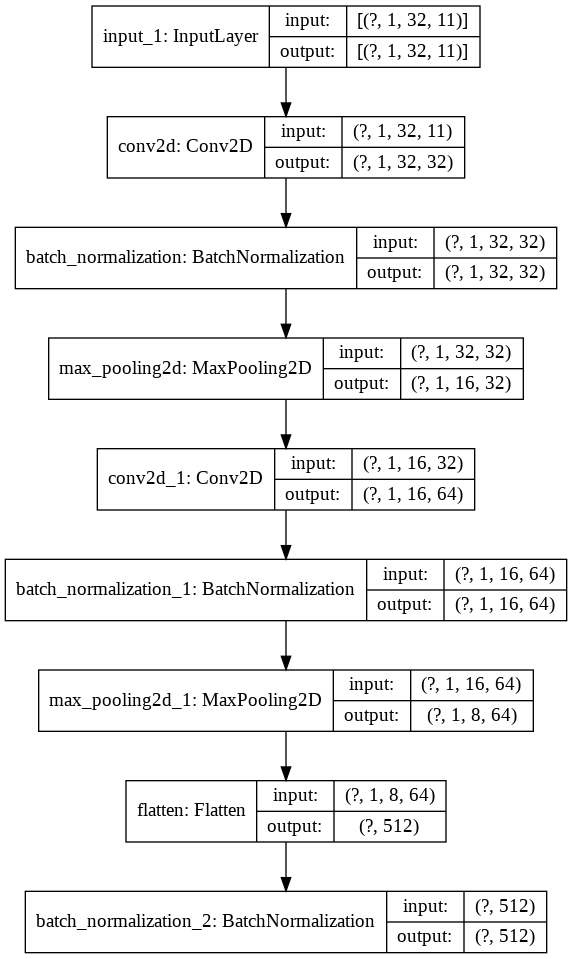

In [ ]:
keras.utils.plot_model(cnn_keras, "cnn_keras.png", show_shapes=True)

In [ ]:
# define two sets of inputs
inputA = layers.Input(shape=(time_steps,1,32,11), name="time_series")
inputB = layers.Input(shape=(1,32,36), name="soil")

# the first branch operates on the first input
x = layers.TimeDistributed(cnn_keras)(inputA)
x = layers.LSTM(256,return_sequences=True)(x)#256
x = layers.Dense(64)(x)
x = layers.Flatten()(x)
x = keras.Model(inputs=inputA, outputs=x)

# the second branch opreates on the second input
y = layers.Conv2D(48,(1,2), activation='relu',input_shape=(1,32,36),padding='same')(inputB)#32
y = layers.BatchNormalization()(y)
y = layers.MaxPool2D((1,2))(y)#though this is not mentioned in paper
y = layers.Conv2D(64,(1,2),activation='relu',padding='same')(y)#64
y = layers.BatchNormalization()(y)
y = layers.MaxPool2D((1,2))(y)
y = layers.Flatten()(y)
y = keras.Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = layers.concatenate([x.output, y.output])
# print(x.output.shape)
# print(y.output.shape)
# apply a FC layer and then a regression prediction on the
# combined outputs
z = layers.Dense(64)(combined)     
z = layers.Dropout(0.5)(z)
z = layers.Dense(1)(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = keras.Model(inputs=[x.input, y.input], outputs=z)

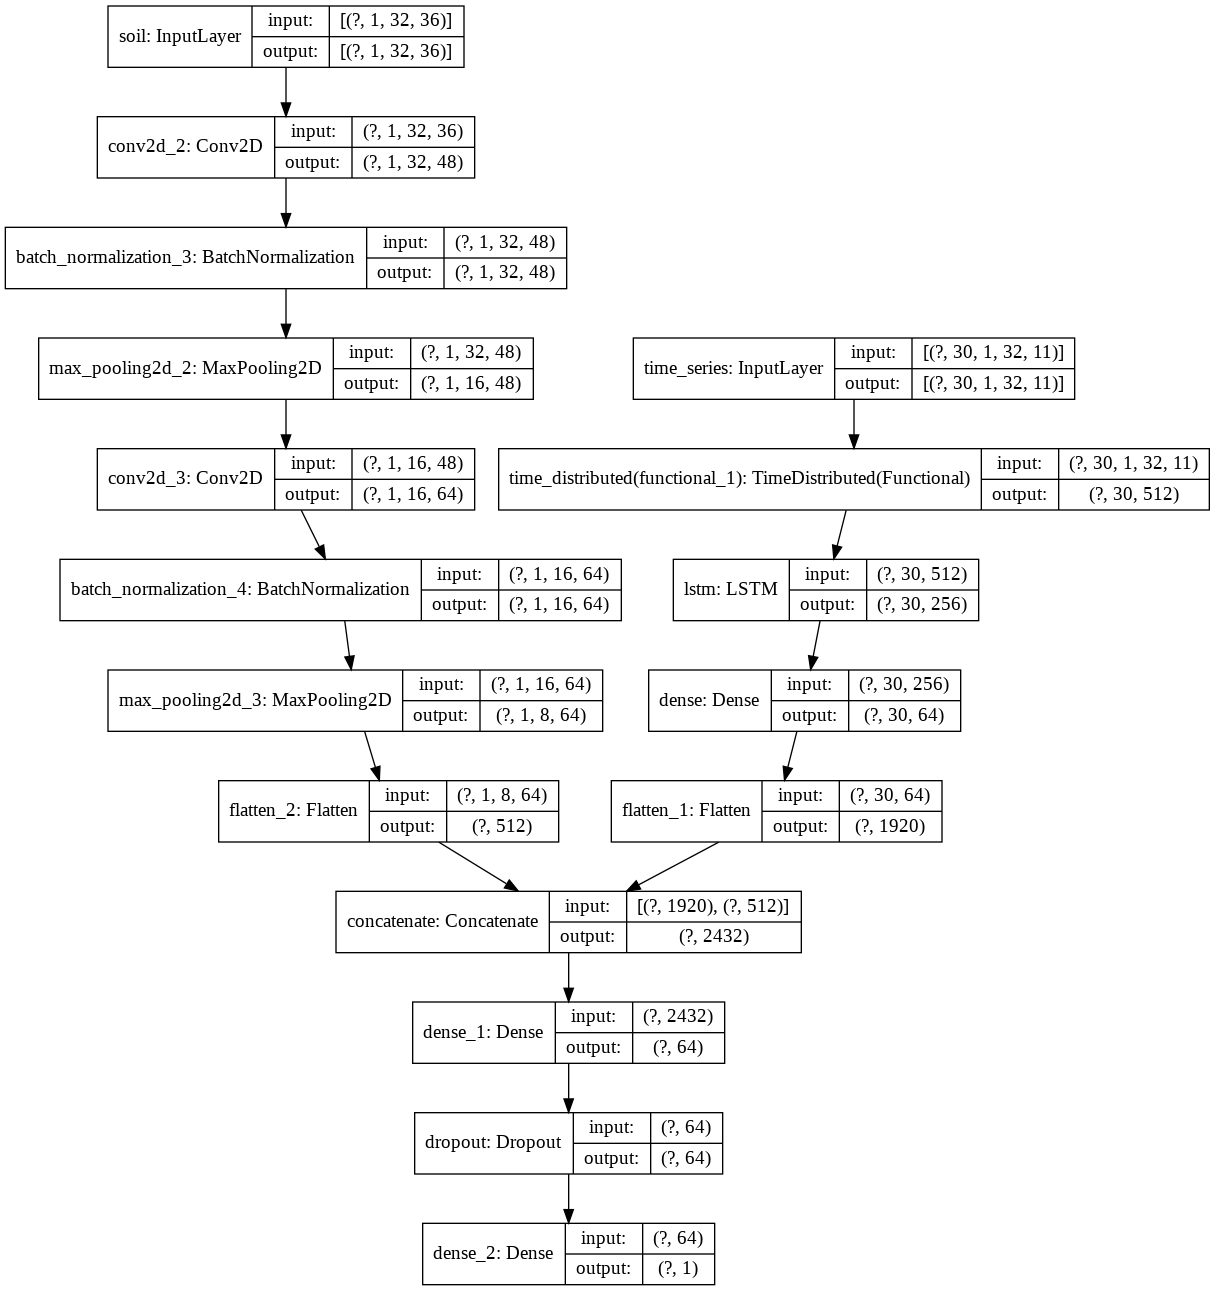

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
a1=100*np.random.rand(500,time_steps,1,no_of_bins,no_of_bands)
a2= np.random.rand(500,1,no_of_bins,no_of_soil_features)
b=np.random.rand(500)
print(a1.shape)
print(a2.shape)
print(b.shape)

(500, 30, 1, 32, 11)
(500, 1, 32, 36)
(500,)


In [ ]:
# Hyperparameters
epochs=200
batch_size=16
learning_rate = 2*1e-3 #though not given in paper

In [ ]:
opt=keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# a1=out_img_composite#[:291,:,:,:,:]    
# # print(a1.shape)
# # ValueError: Input 0 of layer dense_6 is incompatible with the layer: 
# # expected axis -1 of input shape to have value 2624 but received input with shape [None, 2432]
# # a1=100*np.random.rand(291,time_steps,1,no_of_bins,no_of_bands)

# a2=out_soil#[:291,:,:,:]
# b= data['output_yield']#[:291]

In [ ]:
req_indices=data['output_year']==2015
# test_indices=[i in range(test_indices) and test_indices[i]==True]
test_indices=[]
train_indices=[]
for i in range(0, len(req_indices)):
    if req_indices[i]==True:
        test_indices.append(i)
    else:
        train_indices.append(i)
print(len(test_indices))
print(len(train_indices))
# test_a1=out_img_composite
# test_a2=out_soil
# test_b=data

261
2230


In [ ]:
test_out_img_composite=out_img_composite[test_indices,:,:,:,:]
test_out_soil=out_soil[test_indices,:,:,:]
test_yield=data['output_yield'][test_indices]


train_out_img_composite=out_img_composite[train_indices,:,:,:,:]
train_out_soil=out_soil[train_indices,:,:,:]
train_yield=data['output_yield'][train_indices]

In [ ]:
# model.compile(optimizer='adam', loss='mse')
# history=model.fit({"time_series": a1, "soil": a2}, b, batch_size=batch_size, epochs=epochs)
model.compile(optimizer=opt, loss='mse')
history=model.fit([train_out_img_composite,train_out_soil], train_yield, batch_size=batch_size, epochs=epochs)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate([test_out_img_composite,test_out_soil], test_yield, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
17/17 [==============================] - 0s 5ms/step - loss: 1176.6469
test loss, test acc: 1176.6468505859375


In [ ]:
print("Generate predictions for test samples")
predictions = model.predict([test_out_img_composite,test_out_soil])
# print("predictions shape:", predictions.shape)
predictions=predictions.reshape((1,predictions.shape[0]))
#print(predictions)
#print(test_yield)

Generate predictions for test samples


In [ ]:
mape=np.array((abs(predictions-test_yield)/test_yield)*100)
print(np.mean(mape))

18.576343066689777


In [ ]:
# model.save("firstWithSoilBin")

In [ ]:
#model.save(str(str(len(global_processed_files))+"_"+str(epochs)+"_"+str(batch_size)+"_"+str(int(learning_rate*1000))))

In [ ]:
# !pip install pyyaml h5py  # Required to save models in HDF5 format
model_name=str(len(global_processed_files))+'_opt_'+str(epochs)+'_'+str(batch_size)+'_'+str(int(learning_rate*1000))+'_lstm_192_64_cnnsoil_48_64'
print(model_name)
# model.save("/content/drive/MyDrive/data_Lakshya_op/"+model_name+".h5")
model.save(model_name+'.h5')

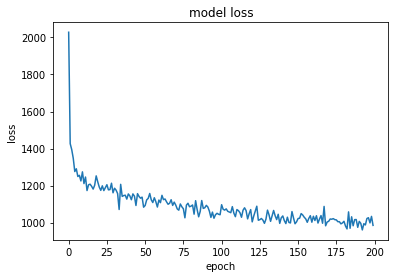

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
keras.models.load_model('/content/drive/MyDrive/data_Lakshya_op/4510_opt_200_16_2_cnn_24_36.h5')
model_name=str('4510_opt_200-16_2_cnn_32_64.h5')

In [ ]:
print("Generate predictions for test samples")
predictions = model.predict([test_out_img_composite,test_out_soil])
# print("predictions shape:", predictions.shape)
predictions=predictions.reshape((1,predictions.shape[0]))
#print(predictions)
#print(test_yield)

Generate predictions for test samples


In [ ]:
mape=np.array((abs(predictions-test_yield)/test_yield)*100)
print(np.mean(mape))

39.43439802379853


In [ ]:
#import torch
from bs4 import BeautifulSoup
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt


def plot_county_errors(data, test_yield, predictions, svg_file=Path('/content/drive/MyDrive/data_Lakshya_op/counties.svg'), save_colorbar=True):
    """
    For the most part, reformatting of
    https://github.com/JiaxuanYou/crop_yield_prediction/blob/master/6%20result_analysis/yield_map.py

    Generates an svg of the counties, coloured by their prediction error.

    Parameters
    ----------
    model: pathlib Path
        Path to the model being plotted.
    svg_file: pathlib Path, default=Path('data/counties.svg')
        Path to the counties svg file used as a base
    save_colorbar: boolean, default=True
        Whether to save a colorbar too.
    """

   # model_sd = torch.load(model, map_location='cpu')

    #model_dir = model.parents[0]

    real_values = test_yield
    pred_values = predictions

    gp = False

    indices =  data['output_index'][test_indices]                     #model_sd['test_indices']]

    pred_err = 100 * abs(pred_values - real_values)/real_values
    pred_dict = {}

    pred_err = np.transpose(pred_err, axes = (1,0))

    #return zip(indices, pred_err)
    for idx, err in zip(indices, pred_err):
        state, county = idx

        state = str(state).zfill(2)
        county = str(county).zfill(3)

        pred_dict[state + county] = err

    print(len(pred_dict))

    #model_info = model.name[:-8].split('_')

    colors = ["#7dcea0","#52be80","#27ae60","#229954", "#1e8449", "#196f3d", "#145a32", "#17202a"]

    _single_plot(pred_dict, svg_file, '/content/drive/MyDrive/data_Lakshya_op/'+model_name+'.svg', colors)

    if gp:
        gp_pred_err = gp_values - real_values
        gp_dict = {}
        for idx, err in zip(indices, gp_pred_err):
            state, county = idx

            state = str(state).zfill(2)
            county = str(county).zfill(3)

            gp_dict[state + county] = err

        _single_plot(gp_dict, svg_file, model_dir / f'{model_info[0]}_{model_info[1]}_gp.svg', colors)

    if save_colorbar:
        _save_colorbar('/content/drive/MyDrive/data_Lakshya_op/colorbar.png', colors)


def _single_plot(err_dict, svg_file, savepath, colors):

    # load the svg file
    svg = open(svg_file,'r').read()
    # Load into Beautiful Soup
    soup = BeautifulSoup(svg, features="html.parser")
    # Find counties
    paths = soup.findAll('path')

    path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1;stroke-width:0.1' \
                 ';stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;marker-start' \
                 ':none;stroke-linejoin:bevel;fill:'

    for p in paths:
        if p['id'] not in ["State_Lines", "separator"]:
            try:
                rate = err_dict[p['id']]
            except KeyError:
                continue
            if rate > 70:
                color_class = 6
            elif rate > 50:
                color_class = 5
            elif rate > 40:
                color_class = 4
            elif rate > 30:
                color_class = 3
            elif rate > 20:
                color_class = 2
            elif rate > 10:
                color_class = 1
            elif rate > 0:
                color_class = 0
            else:
                color_class = 0

            color = colors[color_class]
            p['style'] = path_style + color
    soup = soup.prettify()
    with open(savepath, 'w') as f:
        f.write(soup)


def _save_colorbar(savedir, colors):
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.02, 0.8])

    cmap = mpl.colors.ListedColormap(colors[1:-1])

    cmap.set_over(colors[-1])
    cmap.set_under(colors[0])

    bounds = [0, 10, 20, 30, 40, 50, 60, 70]

    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                   norm=norm,
                                   # to use 'extend', you must
                                   # specify two extra boundaries:
                                   boundaries=[0] + bounds + [70],
                                   extend='both',
                                   ticks=bounds,  # optional
                                   spacing='proportional',
                                   orientation='vertical')
    plt.savefig(savedir, dpi=300, bbox_inches='tight')


261


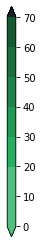

In [ ]:
a = plot_county_errors(data, test_yield, predictions, svg_file=Path('/content/drive/MyDrive/data_Lakshya_op/counties.svg'), save_colorbar=True)